# Train and evalutation guide

(heavily inspierd by an [official guide](https://keras.io/guides/training_with_built_in_methods/))

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## First complete example

In [2]:
# load and prepare mnist data (train, val and test)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [3]:
# model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='easy_model')
model.summary()

# compile model
model.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

Model: "easy_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [4]:
# fit model
print('Fit model on training data')
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=3,
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/3
391/391 [==============================] - 4s 9ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.1940 - val_sparse_categorical_accuracy: 0.9457
Epoch 2/3
391/391 [==============================] - 4s 9ms/step - loss: 0.1877 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1412 - val_sparse_categorical_accuracy: 0.9600
Epoch 3/3
391/391 [==============================] - 4s 9ms/step - loss: 0.1400 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1324 - val_sparse_categorical_accuracy: 0.9619


In [5]:
history.history

{'loss': [0.39792370796203613, 0.18771925568580627, 0.13999520242214203],
 'sparse_categorical_accuracy': [0.8897200226783752,
  0.944159984588623,
  0.9589599967002869],
 'val_loss': [0.19398635625839233, 0.1411861628293991, 0.13242247700691223],
 'val_sparse_categorical_accuracy': [0.9456999897956848,
  0.9599999785423279,
  0.961899995803833]}

In [6]:
# evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# generate predictions on new data using predict
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 1s 6ms/step - loss: 0.1432 - sparse_categorical_accuracy: 0.9577
test loss, test acc: [0.1431911438703537, 0.9577000141143799]
Generate predictions for 3 samples
1/1 [==============================] - 0s 250ms/step
predictions shape: (3, 10)


## The compile() method: losses, metrics and optimizers

In [7]:
# this
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# equals to
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [8]:
# for later reuse
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

### Custom losses

In [9]:
# many losses, metrics and optimizers are already in the API, otherwise
# it's something like this
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# we need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 6s 6ms/step - loss: 0.0160


In [10]:
# If you need a loss function that takes in parameters beside y_true and y_pred,
# you can subclass the tf.keras.losses.Loss class and implement the following 
# methods:
#   - __init__(self): accept parameters to pass during the call of your loss function
#   - call(self, y_true, y_pred): use the targets (y_true) and the model 
#                     predictions (y_pred) to compute the model's loss

class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.0385


### Custom metrics

In [11]:
# Create custom metrics by subclassing the tf.keras.metrics.Metric class. 
#
# You will need to implement 4 methods:
#   __init__(self), in which you will create state variables for your metric.
#   update_state(self, y_true, y_pred, sample_weight=None), which uses the 
#        targets y_true and the model predictions y_pred to update the state variables.
#   result(self), which uses the state variables to compute the final results.
#   reset_state(self), which reinitializes the state of the metric.

class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # the state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 4s 4ms/step - loss: 0.3387 - categorical_true_positives: 45203.0000
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1631 - categorical_true_positives: 47594.0000
Epoch 3/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1176 - categorical_true_positives: 48223.0000


### Non-standard losses and metrics

In [12]:
# There are also non-standard losses and metrics (not computed directly from 
# y_true and y_pred): a regularization loss may only require the activation of 
# a layer (there are no targets in this case), and this activation may not be a 
# model output.

# In such cases, you can call self.add_loss(loss_value) from inside the call 
# method of a custom layer. Losses added in this way get added to the "main" 
# loss during training (the one passed to compile()).

class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# the displayed loss will be much higher than before due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 2.5076


In [13]:
# the same can be done for metrics

class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # `aggregation` defines how to aggregate the per-batch values over each epoch
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.3364 - std_of_activation: 0.9801


In [14]:
# you can also use the functional API
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

# model.add_loss(loss_tensor)
model.add_loss(tf.reduce_sum(x1) * 0.1)

# model.add_metric(metric_tensor, name, aggregation)
model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean") 

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 2.5205 - std_of_activation: 0.0021


In [15]:
# When you pass losses via add_loss(), it becomes possible to call compile() 
# without a loss function, since the model already has a loss to minimize.

# Consider the following LogisticEndpoint layer: it takes as inputs targets & 
# logits, and it tracks a crossentropy loss via add_loss(). It also tracks 
# classification accuracy via add_metric().

class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # compute the training-time loss value and add it to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # log accuracy as a metric and add it to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

In [16]:
# Can be used in a model with two inputs (input data & targets), compiled 
# without a loss argument, like this:

import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 362ms/step - loss: 0.9305 - binary_accuracy: 0.0000e+00


## Train and evaluation with tf.Dataset

In [17]:
# tf.data.Dataset is fast, scalable, takes care of shuffling and
# slicing data, interacts with a model attributes

model = get_compiled_model()

# training Dataset (shuffle and slice)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching, # we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)

dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 4s 4ms/step - loss: 0.3472 - sparse_categorical_accuracy: 0.9022
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9517
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1180 - sparse_categorical_accuracy: 0.9644
Evaluate
157/157 [==============================] - 1s 5ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9602


{'loss': 0.12969794869422913,
 'sparse_categorical_accuracy': 0.9602000117301941}

In [18]:
# you can use `steps_per_epoch` to train only on a few batches per epoch
# NB the next will be consecutive since the dataset is not reset at the end
# of each poch

model = get_compiled_model()

# training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 1s 4ms/step - loss: 0.8013 - sparse_categorical_accuracy: 0.7884
Epoch 2/3
100/100 [==============================] - 0s 5ms/step - loss: 0.3735 - sparse_categorical_accuracy: 0.8972
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3269 - sparse_categorical_accuracy: 0.9052


In [19]:
# can also pass a validation tf.data.Dataset, eventually with `validation_steps`

model = get_compiled_model()

# training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 5s 6ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.9051 - val_loss: 0.1945 - val_sparse_categorical_accuracy: 0.9435


## Sample and class weights

In [20]:
# class weights

import numpy as np

class_weight = {
    0: 1.0, 1: 1.0,
    2: 1.0, 3: 1.0,
    4: 1.0, 5: 2.0, # more important
    6: 1.0, 7: 1.0,
    8: 1.0, 9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 4s 5ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.9020


In [21]:
# sample weight

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 4s 4ms/step - loss: 0.3708 - sparse_categorical_accuracy: 0.9031


In [22]:
# example with tf.data.Dataset

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# create a Dataset that includes sample weights (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# model
model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 4s 4ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.9017


## Multi input and multi output models

In [23]:
# two inputs: a timeseries and an image
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2]) # shared layer

# two outputs
score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

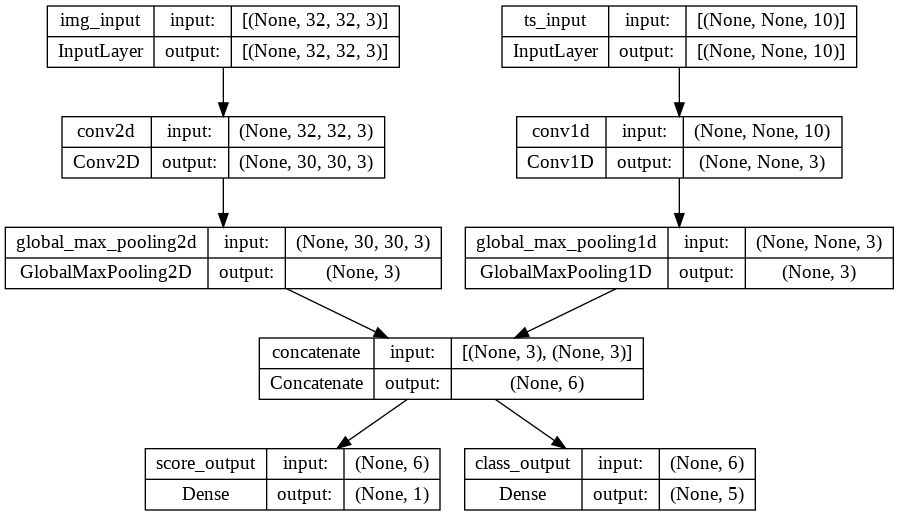

In [24]:
# plot the model
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [25]:
# per-output losses and metrics, with weights
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

In [26]:
# generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 1s 14ms/step - loss: 19.7446 - score_output_loss: 0.3279 - class_output_loss: 19.0888 - score_output_mean_absolute_percentage_error: 360.4246 - score_output_mean_absolute_error: 0.4873 - class_output_categorical_accuracy: 0.2000


In [27]:
# fit using tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 22ms/step - loss: 20.5048 - score_output_loss: 0.2443 - class_output_loss: 20.0162 - score_output_mean_absolute_percentage_error: 316.8139 - score_output_mean_absolute_error: 0.4101 - class_output_categorical_accuracy: 0.2000


## Callbacks

In [28]:
# most useful: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Tensorboard

model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", # stop training when `val_loss` is no longer improving
        min_delta=1e-2, # "no longer improving" being defined as "no better than 1e-2 less"
        patience=2, # "no longer improving" being further defined as "for at least 2 epochs"
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 0.3648 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.2424 - val_sparse_categorical_accuracy: 0.9275
Epoch 2/20
625/625 [==============================] - 2s 4ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.1662 - val_sparse_categorical_accuracy: 0.9502
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.1613 - val_sparse_categorical_accuracy: 0.9527
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.1402 - val_sparse_categorical_accuracy: 0.9578
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.1479 - val_sparse_categorical_accuracy: 0.9587
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0658 - sparse_categorica

### Custom callbacks

In [29]:
# A custom callback has access to its associated model through the class 
# property self.model.
# Simple example saving a list of per-batch loss values during training:

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

### Model checkpoint

In [30]:
# When training model on relatively large datasets, it's crucial to save 
# checkpoints of your model at frequent intervals.
# The easiest way to achieve this is with the ModelCheckpoint callback:

model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", # path where to save the model
        save_best_only=True,  # only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
612/625 [============================>.] - ETA: 0s - loss: 0.3739 - sparse_categorical_accuracy: 0.8953
Epoch 1: val_loss improved from inf to 0.22428, saving model to mymodel_1
625/625 [==============================] - 4s 6ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2243 - val_sparse_categorical_accuracy: 0.9325
Epoch 2/2
613/625 [============================>.] - ETA: 0s - loss: 0.1660 - sparse_categorical_accuracy: 0.9505
Epoch 2: val_loss improved from 0.22428 to 0.17984, saving model to mymodel_2
625/625 [==============================] - 3s 5ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1798 - val_sparse_categorical_accuracy: 0.9463


In [31]:
# Fault-tolerance with ModelCheckpoint callbacks: the ability to restart 
# training from the last saved state of the model in case training gets 
# randomly interrupted. Here's a basic example:

import os

# prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # either restore the latest model, or create a fresh one if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches. We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]

model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3028 - sparse_categorical_accuracy: 0.9121
